# MNIST Data Wrangling and Exploration
The purpose of this notebook is to adequately understand, describe, and explore the mnist data set that will be used in this project.

In [1]:
import os
while os.path.basename(os.getcwd()) != 'CSDGAN':
    os.chdir('..')
from utils.data_loading import load_raw_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torchvision.utils as vutils
%matplotlib inline

Below is a helper function that we will use to visualize images throughout this notebook:

In [2]:
def show_grid(img):
    im = vutils.make_grid(img)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    plt.show()

### Importing data
Note that I have written a helper function to load in the desired data set. If you have not already downloaded
the data sets to the appropriate directory, this can be done simply by running the following code:

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:01, 6946249.02it/s]                             


Extracting downloads/MNIST/raw/train-images-idx3-ubyte.gz to downloads/MNIST/raw


32768it [00:00, 281306.32it/s]                           
0it [00:00, ?it/s]

Extracting downloads/MNIST/raw/train-labels-idx1-ubyte.gz to downloads/MNIST/raw


1654784it [00:00, 3110978.25it/s]                            
8192it [00:00, 116659.16it/s]


Extracting downloads/MNIST/raw/t10k-images-idx3-ubyte.gz to downloads/MNIST/raw
Extracting downloads/MNIST/raw/t10k-labels-idx1-ubyte.gz to downloads/MNIST/raw
Processing...
Done!


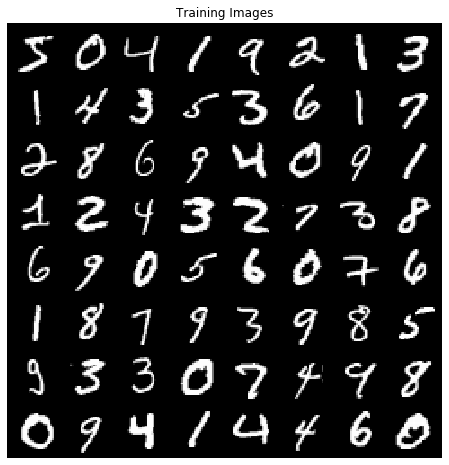

In [3]:
mnist = load_raw_dataset('MNIST')
images = mnist[0].data[:64].view(-1, 1, 28, 28).float()
images = images / 255
show_grid(images)

### Inspecting the data

In [4]:
print("Train set is of length:",len(mnist[0]))
print("Test set is of length:",len(mnist[1]))
print("Each image is of size:",np.array(mnist[0][0][0]).shape)

Train set is of length: 60000
Test set is of length: 10000
Each image is of size: (28, 28)


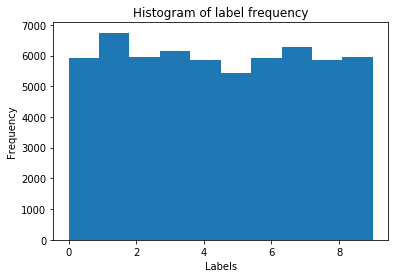

In [5]:
plt.hist(mnist[0].targets.numpy())
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Histogram of label frequency')
plt.show()

Looks like our labels consist of 0-9, and we have a balanced number of each class.

### Data Augmentation
Let's experiment a little bit with data augmentation in pytorch! Data augmentation consists primarily of applying various minor adjustments to the images such that while the image is clearly of the same class (especially to a human), to a computer it is a completely different image due to it containing significantly different pixels in different locations. This results in artificially increasing the size of our data set and improving model performance. We will later compare this approach to using the GAN to generate images!

In [6]:
import torchvision.transforms as t
labels = mnist[0].targets[:64]
def trnsfm_batch(img, labels):
    PIL = torchvision.transforms.ToPILImage()
    TNSR = torchvision.transforms.ToTensor()
    crop_trnsfm = t.RandomResizedCrop(28, scale = (0.75, 1.0), ratio=(0.75, 1.3333))
    affine_trnsfm = t.RandomAffine((-15, 15))
    vert_trnsfm = t.RandomVerticalFlip(p=0.5)
    hor_trnsfm = t.RandomHorizontalFlip(p=0.5)
    final_trnsfm = t.Compose([crop_trnsfm, affine_trnsfm])
    spcl_trnsfm = t.Compose([vert_trnsfm, hor_trnsfm])
    spcl_list = [1, 8]
    out = torch.empty_like(img)
    for i in range(64):
        tmp = img[i].view(28, 28)
        tmp = PIL(tmp)
        tmp = final_trnsfm(tmp)
        if labels[i] in spcl_list:
            tmp = spcl_trnsfm(tmp)
        tmp = TNSR(tmp)
        out[i] = tmp
    return out

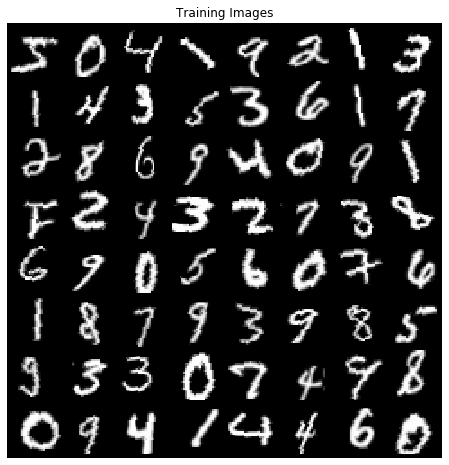

In [7]:
test = trnsfm_batch(images, labels)
show_grid(test)

It's easiest to see if you run it repeatedly and observe how they change. You can also try messing with the parameters of the transformations in the function!